In [8]:
import numpy as np
import pandas as pd
import torch

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

In [13]:
root_path = '/Users/HOME/Desktop/Hackaton/Data/'

f2 = pd.read_csv(root_path + '2019Floor1.csv')

f2 = f2.rename(columns = {'fecha': 'Date'})
f2['Date'] = pd.to_datetime(f2['Date'], format = 'ISO8601')
f2 = f2.set_index('Date')
f2 = f2.asfreq('3H')
f2 = f2.sort_index()
f2 = f2.fillna(0)
f2

,z1_Light(kW),z2_Light(kW),z3_Light(kW),z4_Light(kW)
Date,,,,
2019-03-01 03:00:00,12.12,6.25,14.45,33.34
2019-03-01 06:00:00,0.01,3.96,19.01,38.69
2019-03-01 09:00:00,0.01,5.34,9.14,0.05
2019-03-01 12:00:00,0.02,8.47,18.59,0.07
2019-03-01 15:00:00,0.02,8.40,18.54,0.07
...,...,...,...,...
2019-12-30 12:00:00,0.01,5.18,12.86,3.80
2019-12-30 15:00:00,0.01,5.27,12.99,3.80
2019-12-30 18:00:00,0.02,6.49,25.25,13.67


In [15]:
ex = pd.read_csv(root_path + '2019weather.csv', encoding='cp949')

ex['일시'] = pd.to_datetime(ex['일시'], format = 'ISO8601')
ex = ex.set_index('일시')
ex = ex.asfreq('3H')
ex = ex.sort_index()
ex

,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa)
일시,,,,,,
2019-03-01 03:00:00,3.9,0.0,0.2,0,73,1013.8
2019-03-01 06:00:00,2.6,0.0,0.8,360,71,1015.0
2019-03-01 09:00:00,7.2,0.0,3.3,270,46,1015.7
2019-03-01 12:00:00,12.0,0.0,5.2,290,24,1014.1
2019-03-01 15:00:00,14.1,0.0,3.4,290,22,1012.6
...,...,...,...,...,...,...
2019-12-30 12:00:00,5.5,0.0,2.1,270,88,1015.2
2019-12-30 15:00:00,10.5,0.0,2.5,270,73,1013.6
2019-12-30 18:00:00,9.2,0.0,2.6,290,71,1014.5


In [17]:
df = pd.concat([ex, f2], join = 'outer', axis = 1)

df.reset_index(drop = False, inplace= True)
#df.to_csv('/Users/HOME/Desktop/Hackaton/Result/total_Data.csv')
df

,index,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),z1_Light(kW),z2_Light(kW),z3_Light(kW),z4_Light(kW)
0,2019-03-01 03:00:00,3.9,0.0,0.2,0,73,1013.8,12.12,6.25,14.45,33.34
1,2019-03-01 06:00:00,2.6,0.0,0.8,360,71,1015.0,0.01,3.96,19.01,38.69
2,2019-03-01 09:00:00,7.2,0.0,3.3,270,46,1015.7,0.01,5.34,9.14,0.05
3,2019-03-01 12:00:00,12.0,0.0,5.2,290,24,1014.1,0.02,8.47,18.59,0.07
4,2019-03-01 15:00:00,14.1,0.0,3.4,290,22,1012.6,0.02,8.40,18.54,0.07
...,...,...,...,...,...,...,...,...,...,...,...
2435,2019-12-30 12:00:00,5.5,0.0,2.1,270,88,1015.2,0.01,5.18,12.86,3.80
2436,2019-12-30 15:00:00,10.5,0.0,2.5,270,73,1013.6,0.01,5.27,12.99,3.80
2437,2019-12-30 18:00:00,9.2,0.0,2.6,290,71,1014.5,0.02,6.49,25.25,13.67
2438,2019-12-30 21:00:00,6.4,0.0,5.7,290,50,1015.4,8.28,4.28,33.53,12.35


Train dates : 0 --- 2139  (n=2140)
Test dates  : 2140 --- 2439  (n=300)


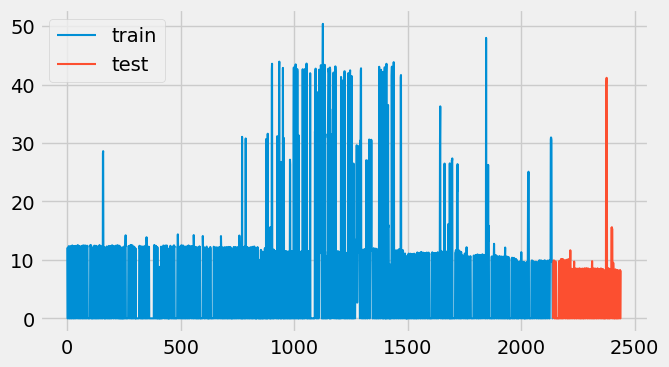

In [20]:
steps = 300
data_train = df[:-steps]
data_test  = df[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(7, 4))
data_train['z1_Light(kW)'].plot(ax=ax, label='train')
data_test['z1_Light(kW)'].plot(ax=ax, label='test')
ax.legend();

In [21]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 100
             )

forecaster.fit(y=data_train['z1_Light(kW)'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100] 
Transformer for y: None 
Transformer for exog: None 
Window size: 100 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 2139] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 

In [22]:
steps = 300
predictions = forecaster.predict(steps=steps)
predictions.head(7)

2140    2.9456
2141    7.3117
2142    7.0084
2143    7.0649
2144    7.7826
2145    6.7233
2146    0.2207
Name: pred, dtype: float64

In [23]:
#이 값보다 작으면 성공한거임
naive_forecast = df['z1_Light(kW)'][-steps-1:-1]
tmp = data_test['z1_Light(kW)']

naive_tensor = torch.tensor(naive_forecast.values)
test_tensor = torch.tensor(tmp.values)

loss = torch.nn.MSELoss()
naive_output = loss(naive_tensor, test_tensor)
print(f"### naive_forecast(mse): {naive_output} ####")

### naive_forecast(mse): 26.41872466666667 ####


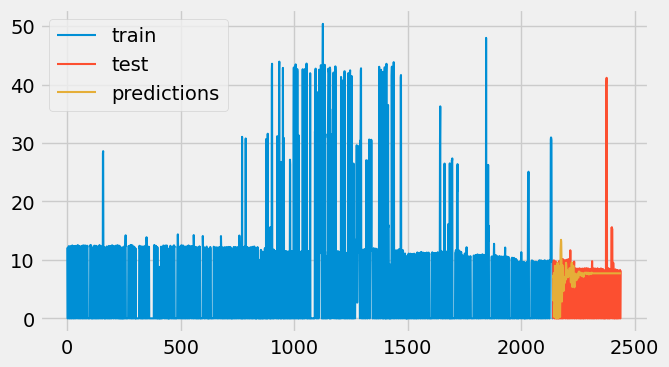

In [24]:
fig, ax = plt.subplots(figsize=(7, 4))
data_train['z1_Light(kW)'].plot(ax=ax, label='train')
data_test['z1_Light(kW)'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [36]:
error_mse = mean_squared_error(
                y_true = data_test['z1_Light(kW)'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 39.6502721277
